In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets.cityscapes import setupDatasetsAndLoaders

In [2]:
# CUDA check
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)
# device = ""

True
cuda


In [3]:
print(torch.__version__)

1.4.0


### Datasets and Dataloader

image name: ('ulm_000036_000019_leftImg8bit', 'ulm_000039_000019_leftImg8bit', 'ulm_000083_000019_leftImg8bit', 'ulm_000005_000019_leftImg8bit', 'ulm_000000_000019_leftImg8bit', 'ulm_000066_000019_leftImg8bit', 'ulm_000082_000019_leftImg8bit', 'ulm_000072_000019_leftImg8bit')
image tensor size: torch.Size([8, 3, 224, 448])
annotated output tensor size: torch.Size([8, 224, 448])


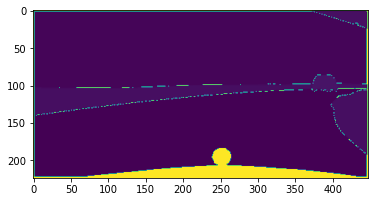

In [4]:
train_set, val_set, test_set, train_loader, val_loader, test_loader = setupDatasetsAndLoaders('./data', batch_size=8)

for sample in train_loader:
    imgSeq, annotatedOutput, imgName = sample

    print(f'image name: {imgName}')
    print(f'image tensor size: {imgSeq[-1].shape}')
    print(f'annotated output tensor size: {annotatedOutput.shape}')

    # plt.imshow(imgSeq[-1][0].permute(1, 2, 0))
#     print(annotatedOutput[0,200:400,0:200])
    plt.imshow(annotatedOutput[0])
    break

### Model

In [5]:
# Define AutoEncoder Model for MNIST
class MNIST_Autoencoder(nn.Module):

    def __init__(self, num_classes=19,pool_scales=(1,2,3,6)):
        
        # Init from nn.Module
        super().__init__()
        
        # Encoder part will be a simple sequence of Conv2d+ReLU.
        self.encoder = nn.Sequential(nn.Conv2d(3, 16, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(64, 128, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 256, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(256, 256, 3, stride = 2, padding = 1),
                                     nn.ReLU(),
                                     nn.Conv2d(256, 512, 3),
                                     nn.ReLU(),
                                     nn.Conv2d(512, num_classes, 1))
        
        
        # Decoder part will be a simple sequence of TransposeConv2d+ReLU.
        # Finish with Sigmoid
        self.decoder = nn.Sequential(nn.ConvTranspose2d(num_classes, num_classes, 3),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(num_classes, num_classes, 3, stride = 2, padding = 1, output_padding = 1),
                                     nn.ReLU())
        
        
        #PSP variables
        self.pool_scale = pool_scales
        dim = 16

        self.psp = []
        for scale in pool_scales:
            self.psp.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                nn.Conv2d(num_classes, dim, kernel_size=1, bias=False),
#                 nn.BatchNorm2d(dim),
                nn.ReLU(inplace=True)
            ))
        self.psp = nn.ModuleList(self.psp)

        self.conv_last = nn.Sequential(
#             nn.Conv2d(num_classes+len(pool_scales)*dim, dim,
#                       kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(dim),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.1),
            nn.Conv2d(num_classes+len(pool_scales)*dim, num_classes, kernel_size=1)
        )
        

    def forward(self,x):
        
        # Forward is encoder into decoder
        x = self.encoder(x)
        x = self.decoder(x)
        
        
        #Referred from https://github.com/CSAILVision/semantic-segmentation-pytorch/blob/e21b8e2bfb1cb145941c36468fc807f20146b71a/models.py
#         print("After Autoencoder:",x.shape)
        input_size = x.size()
        psp_out = [x]
        for pool_scale in self.psp:
            pool = pool_scale(x)
#             print("After pooling:",pool.shape)
            p_layer = nn.functional.interpolate(
                pool,
                (input_size[2], input_size[3]),
                mode='bilinear')
#             print("After upsampling:",p_layer.shape)
            psp_out.append(p_layer)            
        x = torch.cat(psp_out, 1)
#         print("After concatenation:",x.shape)
        x = self.conv_last(x)
#         print("After last convolution:",x.shape)
        
        return x

### Train

In [6]:
# Initialize MNIST Autoencoder
torch.manual_seed(10)
model = MNIST_Autoencoder().to(device)

In [7]:
# for sample in train_loader:
#     imgSeq, annotatedOutput, imgName = sample
#     model(imgSeq[0].to(device))
#     break

In [8]:
# Defining Parameters
# - MSE Loss, which will be our reconstruction loss for now
# - Adam as optimizer
# - 20 Epochs
# - 128 as batch size
num_epochs = 20
batch_size = 1
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(),weight_decay = 1e-5)

In [9]:
# Train
outputs_list = []
loss_list = []
model.train()
for epoch in range(num_epochs):
    for data in tqdm(train_loader):
        
        imgSeq, annotatedOutput, imgName = data
        
        # Send data to device
        img = Variable(imgSeq[-1])
        img = img.to(device)
        
        # Forward pass
        output = model(img)
        annotatedOutput = annotatedOutput.to(device).long()
#         output = output.argmax(dim=1)
        loss = loss_fn(output, annotatedOutput)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    outputs_list.append((epoch, img, output),)
    loss_list.append(loss.item())
    torch.save(model.state_dict(),"PSP_Model_epoch_"+str(epoch)+".pt")

  0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
  0%|          | 0/9 [00:03<?, ?it/s]


RuntimeError: input and target batch or spatial sizes don't match: target [8 x 224 x 448], input [8 x 19 x 256 x 448] at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/THCUNN/generic/SpatialClassNLLCriterion.cu:23

In [ ]:
torch.save(model.state_dict(),"psp_model_stoppedhalfwayat13epochs.pt")

In [ ]:
torch.manual_seed(10)
model = MNIST_Autoencoder().to(device)
model.load_state_dict(torch.load("PSP_Model_epoch_19.pt"))

In [ ]:
# Display loss
plt.figure()
plt.plot(loss_list)
plt.show()

In [ ]:
model.eval()
for k in range(0, 13, 4):
    plt.figure(figsize = (100, 50))
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        print(item.shape)
        plt.imshow(item[0,:,:])

In [ ]:
 torch.cuda.empty_cache()

In [ ]:
def convertColour(inp, label):
    np_inp = inp.numpy()
    label = label.numpy()
    final = []
    for i, i_label in zip(np_inp, label):
        out = []
        for j, j_label in zip(i, i_label):
            if j_label == 255:
                out.append(l.trainId2color[j_label])
            else:
                out.append(l.trainId2color[j])
        final.append(out)
    return np.asarray(final)

In [ ]:
import datasets.labels as l
import numpy as np
for data in train_loader:

    imgSeq, annotatedOutput, imgName = data

    # Send data to device
    img = Variable(imgSeq[-1])
    img = img.to(device)

    # Forward pass
    output = model(img)
    annotatedOutput = annotatedOutput.to(device).long()
    break
plt.imshow(convertColour(torch.max(output[0].cpu(),0).indices,annotatedOutput[0].cpu()))
print(torch.max(output[0].cpu(),0).indices)